# Building a Predictive Model using Logistic Regression

In this second notebook, I am going to build a Logistic Regression model. My main goal here is to implement a baseline machine learning model that achieves a consistent in-sample and out-of-sample performance.

## Importing libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import quantstats as qs
import ta
import multiprocessing as mp
mp.set_start_method('spawn')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from trading.backtest import Backtest
from trading.model_selection import GridSearch
from trading.analysis import RocAnalysis

First, let's plot our dataset. In this notebook, I split the Development dataset described in the [Technical Indicators notebook](./01-TechnicalIndicators.ipynb) into Training (2010-2014) and Validation (2015-2018) sets.

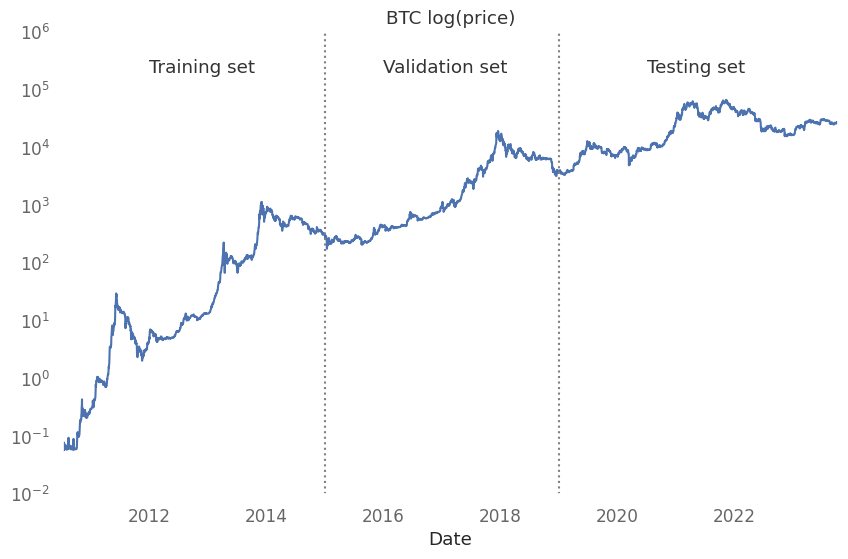

In [2]:
DATASET_FILE = 'data/CMC_BTCUSD.csv'
df = pd.read_csv(DATASET_FILE, header=0, index_col=0, parse_dates=True)
ax = df['Close'].plot(logy=True, title='BTC log(price)')
ax.axvline(pd.to_datetime('2014-12-31'), linestyle='dotted', color='gray')
ax.axvline(pd.to_datetime('2018-12-31'), linestyle='dotted', color='gray')
ax.text(pd.to_datetime('2012-01-01'), 10 ** 5 + 100_000, 'Training set')
ax.text(pd.to_datetime('2016-01-01'), 10 ** 5 + 100_000, 'Validation set')
ax.text(pd.to_datetime('2020-07-01'), 10 ** 5 + 100_000, 'Testing set')
ax.set_ylim((10 ** -2, 10 ** 6))
ax.grid(False)

## Creating the target

The goal of the machine learning model that is going to be developed is to predict Bitcoin's price direction for the next day. Thus, the target labels can be defined as follows:
* 1: "buy signal", if the expected return for the next day is positive; or
* 0: "sell signal" or "do nothing" (if the model is out of the market), otherwise.

Considering the above labels, the development dataset (training + validation) is approximately balanced.

In [3]:
TARGET_WINDOW = 1

def build_target(df, window=1):
    df[f'Return_{window}'] = df['Close'].pct_change(window)
    df[f'TargetReturn_{window}'] = df[f'Return_{window}'].shift(-window)
    df[f'TargetLabel_{window}'] = np.where(df[f'TargetReturn_{window}'] > 0.0, 1, 0)
    df[f'TargetLabel_{window}'] = df[f'TargetLabel_{window}'].astype(int)

build_target(df, TARGET_WINDOW)
df.loc[:'2018-12-31', f'TargetLabel_{TARGET_WINDOW}'].value_counts(normalize=True)

TargetLabel_1
1    0.558824
0    0.441176
Name: proportion, dtype: float64

In [4]:
df.tail()

,Open,High,Low,Close,Volume,Market Cap,Return_1,TargetReturn_1,TargetLabel_1
Date,,,,,,,,,
2023-10-04,27429.074995,27826.657948,27248.106247,27799.394096,1.114336e+10,5.422032e+11,0.013468,-0.013795,0
2023-10-05,27798.647127,28091.861237,27375.601424,27415.911982,1.187725e+10,5.347474e+11,-0.013795,0.019357,1
2023-10-06,27412.122424,28252.537570,27215.552446,27946.596780,1.349239e+10,5.451267e+11,0.019357,0.000796,1
2023-10-07,27946.781633,28028.092087,27870.423458,27968.838871,6.553044e+09,5.455899e+11,0.000796,-0.001207,0
2023-10-08,27971.678107,28102.170391,27740.663024,27935.089581,7.916875e+09,5.449575e+11,-0.001207,NaN,0


## Feature engineering

Before fitting any machine learning model, we must first create a set of features that will be given as input to our models. Here, I consider the following features:
* **RSI**, which has already been explained in the [previous notebook](./01_TechnicalAnalysis.ipynb), is calculated with the standard lookback window of 14 days (or 2 weeks for Bitcoin).
* **Bollinger Channel Percentage Band (BCPB)**, which is a volatility indicator defined by two bands in the $i$-th day:
$$
\text{UBAND}_i = \text{SMA}_i(n) + m \, \sigma(n)
$$
$$
\text{LBAND}_i = \text{SMA}_i(n) - m \, \sigma(n),
$$
  where $\text{SMA}_i(n)$ is the Simple Moving Average of the close price, $n$ is the time window, $\sigma$ is the standard deviation of the close price and $m$ is the number of standard deviations to define the bands. The Percentage Band indicates the location of the price time series with respect to the upper and lower bands, where zero corresponds to the lower band and one corresponds to the upper band. Bollinger Bands are typically calculated over 20 business days (\~1 month) and $m = 2$. Since the Bitcoin market is open everyday, I consider here the value of 28 days (\~4 weeks) and $m = 2$.

* **MACD**, that was also tested in the [previous notebook](./01_TechnicalAnalysis.ipynb). Typically, the MACD is calculated using short and long time windows of 12 and 26 days, respectively. In this notebook, I consider the values of 14 and 28 days which correspond to 2 and 4 weeks, respectively. In addition, the MACD will be calculated as:
$$
\text{MACD}_i(n, m) = \dfrac{\text{EMA}_i(n)}{\text{EMA}_i(m)} - 1,
$$
where $\text{EMA}_i$ refers to the Exponential Moving Average of the $i$-th day. In this definition, MACD is the rate of return between the shorter and the longer EMA.

* **Past Returns (or Rate of Change)**, which is one of the most simple ways to define momentum. Here, we will consider past returns of 1 day, 1 week, 2 weeks, 3 weeks and 4 weeks.

In [5]:
def build_features(df):
    df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
    df['BCPB'] = ta.volatility.bollinger_pband(df['Close'], window=28)
    df['MACD'] = ta.trend.ema_indicator(df['Close'],  window=14) / ta.trend.ema_indicator(df['Close'], window=28) - 1.0
    for w in (1, 7, 14, 21, 28):
        df[f'Return_{w}'] = df['Close'].pct_change(w)
    return df.dropna()

df = build_features(df)
df.tail()

,Open,High,Low,Close,Volume,Market Cap,Return_1,TargetReturn_1,TargetLabel_1,RSI,BCPB,MACD,Return_7,Return_14,Return_21,Return_28
Date,,,,,,,,,,,,,,,,
2023-10-03,27508.251819,27667.192031,27216.001323,27429.979017,1.140781e+10,5.349753e+11,-0.003662,0.013468,1,58.484952,0.874430,0.006194,0.046257,0.008043,0.061805,0.064003
2023-10-04,27429.074995,27826.657948,27248.106247,27799.394096,1.114336e+10,5.422032e+11,0.013468,-0.013795,0,62.254248,0.978212,0.007745,0.054897,0.024598,0.059900,0.079452
2023-10-05,27798.647127,28091.861237,27375.601424,27415.911982,1.187725e+10,5.347474e+11,-0.013795,0.019357,1,56.517655,0.801359,0.008008,0.014594,0.031929,0.033016,0.044806
2023-10-06,27412.122424,28252.537570,27215.552446,27946.596780,1.349239e+10,5.451267e+11,0.019357,0.000796,1,61.768005,0.961178,0.009399,0.038454,0.051432,0.050281,0.078784
2023-10-07,27946.781633,28028.092087,27870.423458,27968.838871,6.553044e+09,5.455899e+11,0.000796,-0.001207,0,61.975241,0.929284,0.010480,0.037115,0.052275,0.052715,0.080058


Next, I break our dataset into training, validation and test. Note that it is necessary to drop the last day of the training and validation sets, to avoid data leakage.

In [6]:
df_train = df.loc[:'2014-12-31'].iloc[:-TARGET_WINDOW].dropna()
df_valid = df.loc['2015-01-01':'2018-12-31'].iloc[:-TARGET_WINDOW].dropna()
df_test = df.loc['2019-01-01':].dropna()

Now, let's plot the features in pairs.

In [7]:
TARGET_COL = f'TargetLabel_{TARGET_WINDOW}'
FEATURES = [c for c in df.columns if c not in ('Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap') and not c.startswith('Target')]
FEATURES

['Return_1',
 'RSI',
 'BCPB',
 'MACD',
 'Return_7',
 'Return_14',
 'Return_21',
 'Return_28']

/home/padilha/miniconda3/envs/crypto-trading-env/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


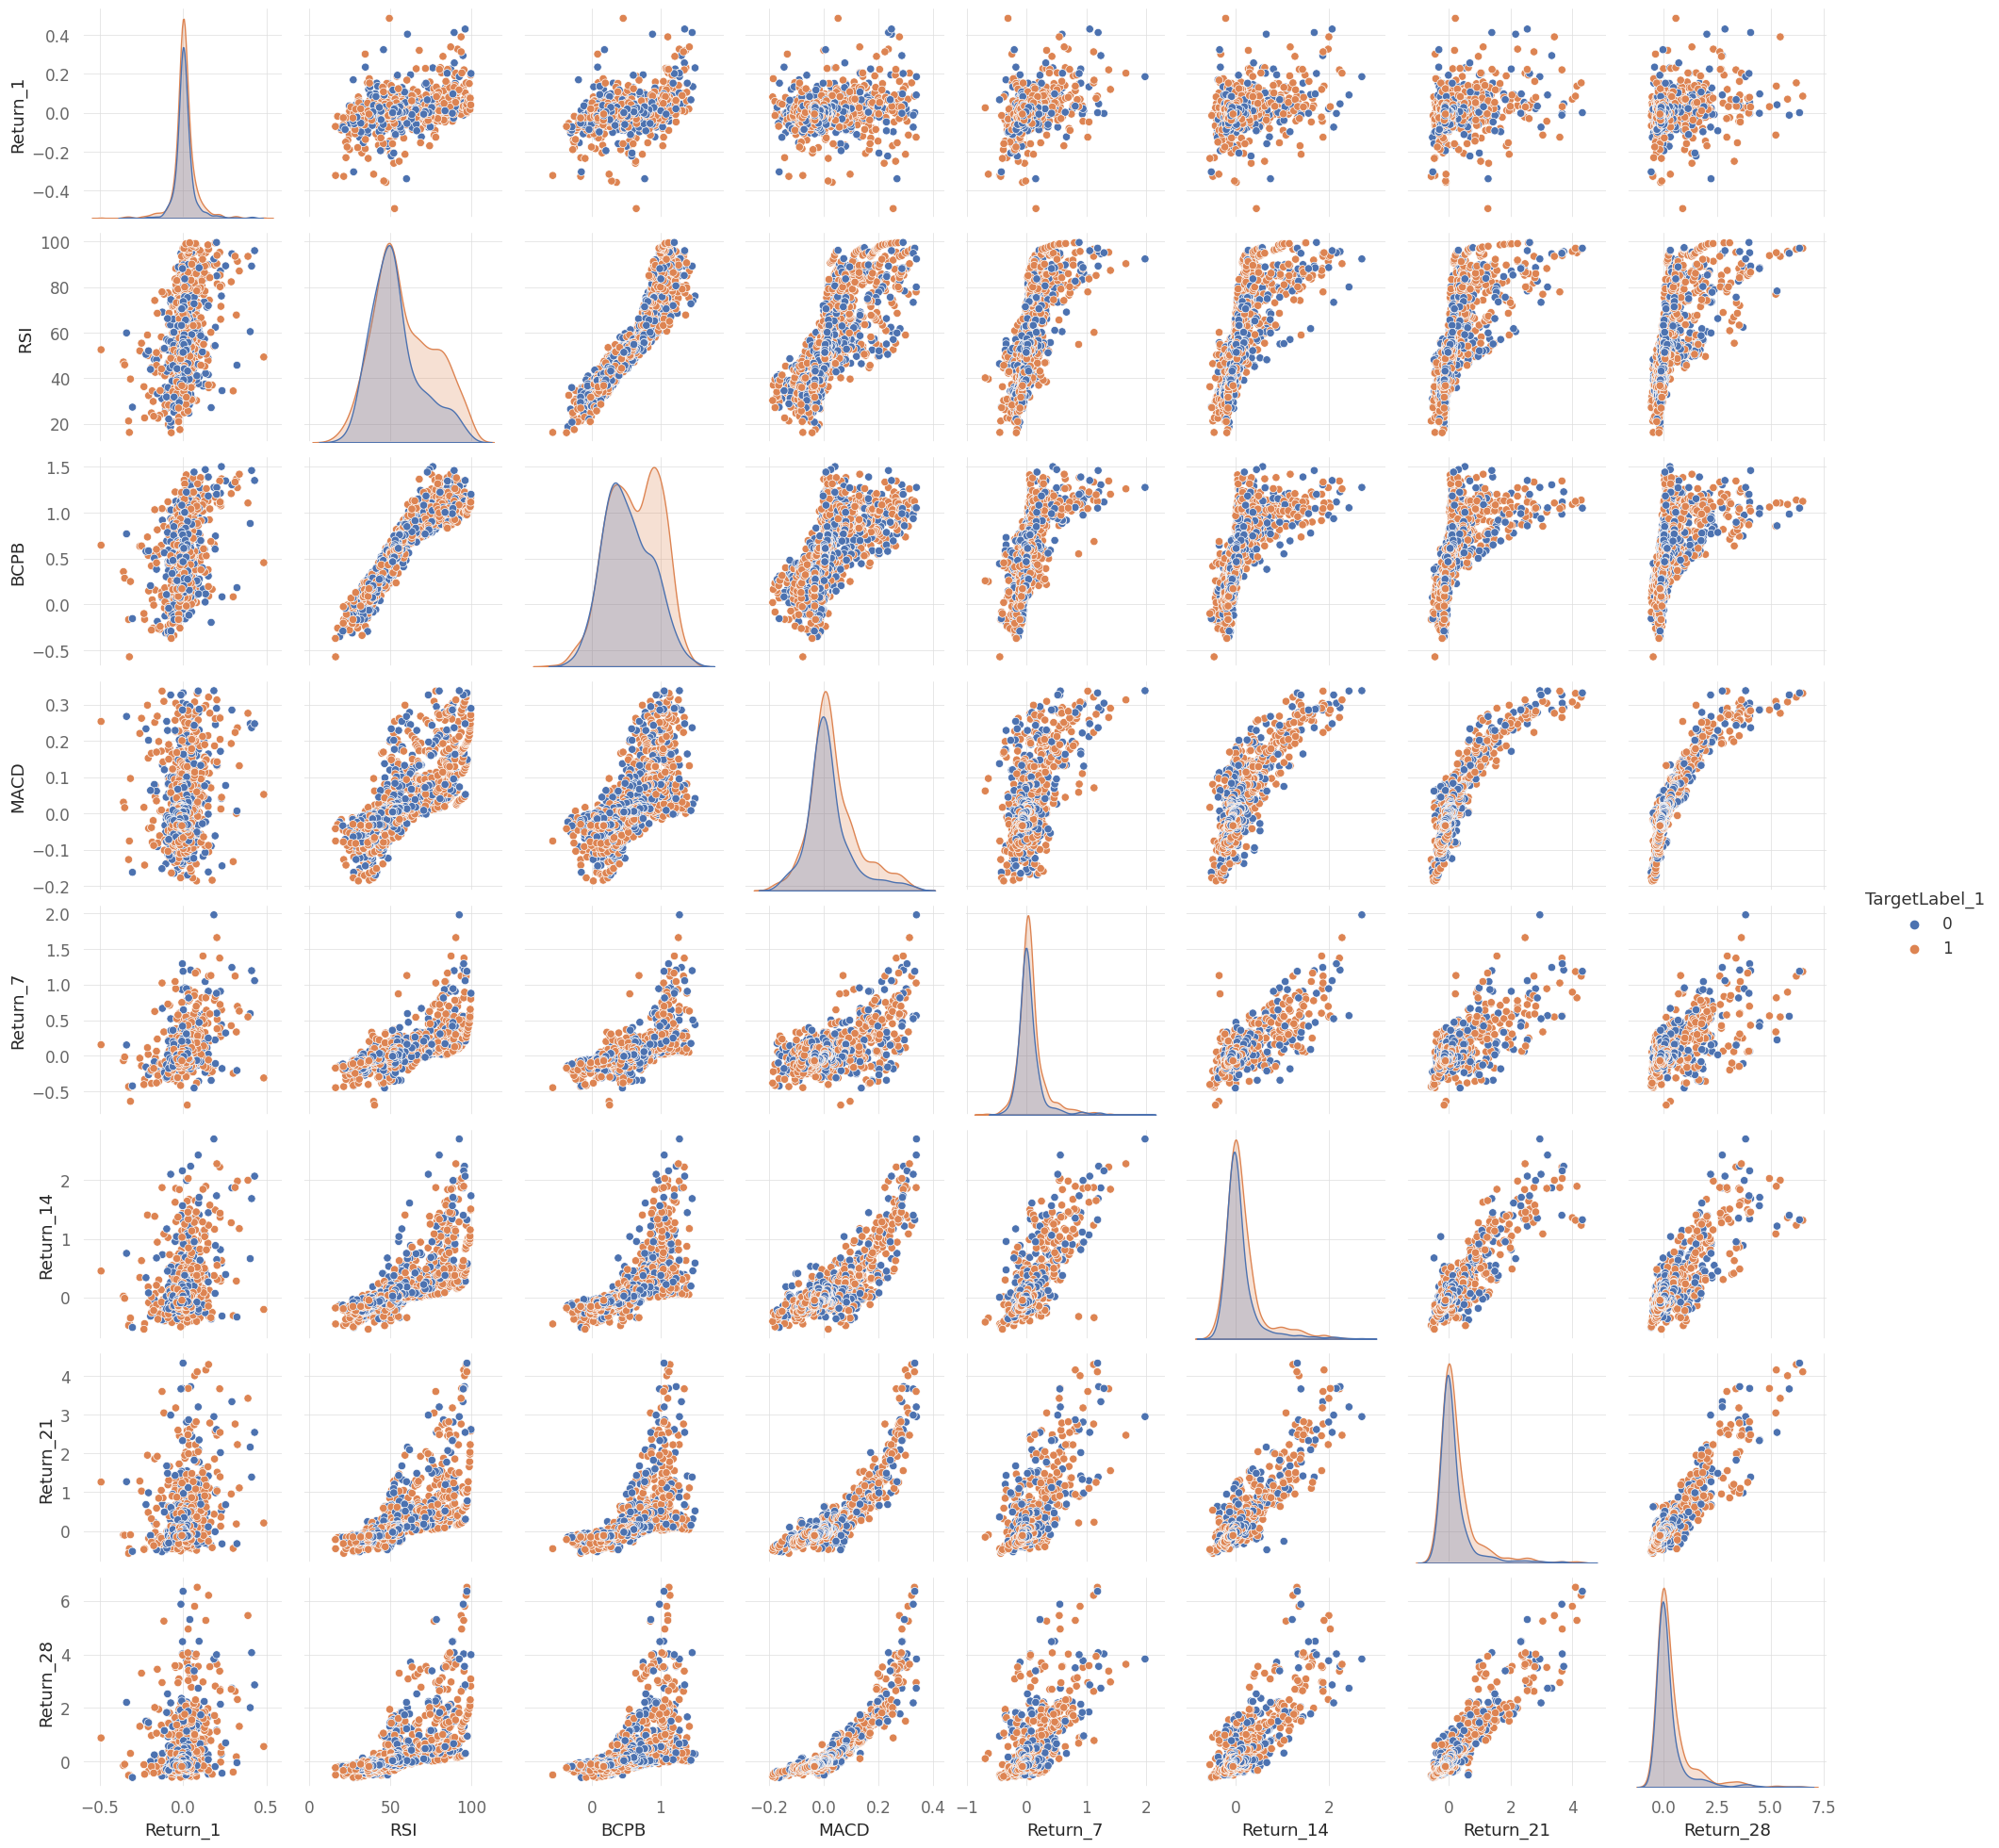

In [8]:
sns.pairplot(df_train[FEATURES + [TARGET_COL]], hue=TARGET_COL)

## Baseline ML Model: Regularized Logistic Regression

Even though the given classes are highly overlapped, as it can be seen in the above plot, let's run a Logistic Regression model, in order to build a quick and simple baseline.

In the following experiments, I will use the [Receiver Operating Characteristic (ROC) Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) to analyze our results (see the [RocAnalysis](./trading/analysis.py) class). The advantage of this type of analysis is that we can later use an objective criterion to choose the best classification threshold for our final classifier.

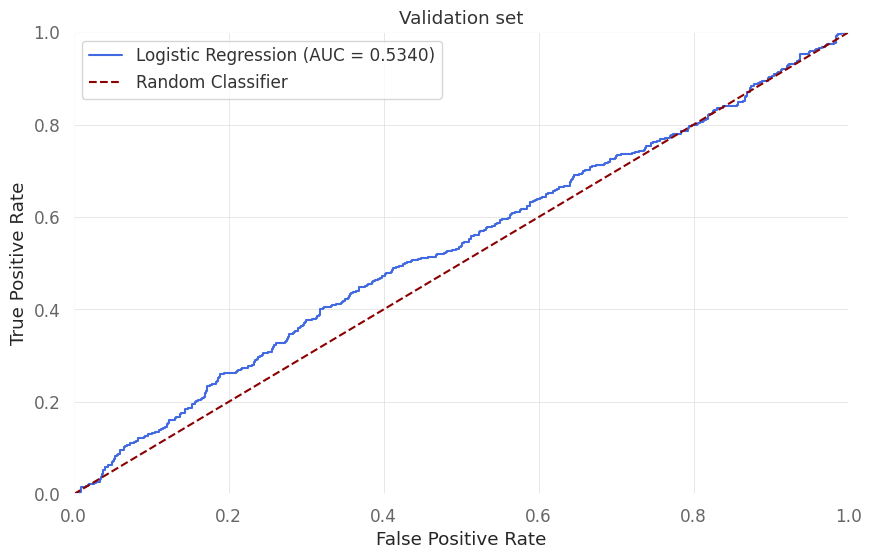

In [9]:
X_train = df_train[FEATURES].values
y_train = df_train[TARGET_COL].values
X_valid = df_valid[FEATURES].values
y_valid = df_valid[TARGET_COL].values

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', LogisticRegression(random_state=42, max_iter=10_000, solver='liblinear'))
])

param_grid = ParameterGrid({
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [1e-4, 1e-3, 1e-2, 1e-1] + list(map(float, range(1, 21))),
})

grid_search = GridSearch(
    model=pipeline,
    param_grid=param_grid,
    n_jobs=2
)

logit = grid_search.fit(X_train, y_train, X_valid, y_valid)
y_proba = logit.predict_proba(X_valid)[:, 1]

logit_roc_validation = RocAnalysis(y_valid, y_proba, 'Logistic Regression')
logit_roc_validation.plot('Validation set')

In [10]:
logit['estimator']

LogisticRegression(C=0.01, max_iter=10000, random_state=42, solver='liblinear')

In [11]:
logit['estimator'].penalty

'l2'

Below I select the best classification threshold, calculated as the best Geometric Mean between the sensitivity (TPR) and specificity (1 - FPR).

In [12]:
logit_best_thr = logit_roc_validation.get_best_thr()
print(f'Logistic Regression best classification threshold: {logit_best_thr:.4f}')
y_valid_pred = (y_proba > logit_best_thr).astype(int)
print(classification_report(y_valid, y_valid_pred))

Logistic Regression best classification threshold: 0.5533
              precision    recall  f1-score   support

           0       0.48      0.59      0.53       650
           1       0.60      0.49      0.54       810

    accuracy                           0.53      1460
   macro avg       0.54      0.54      0.53      1460
weighted avg       0.54      0.53      0.53      1460



From the classification report, we can see that the Logistic Regression model achieved 53% of accuracy in the validation set. In financial markets, the signal-to-noise ratio is generally low. Therefore, a model that can predict next-day movements with more than 50% accuracy can usually be considered an interesting option for a profitable strategy.

Now, let's backtest this baseline model in order to see how it performs in the validation set. As a reference, I also include the results of MAC and the Technical Ensemble for the same period.

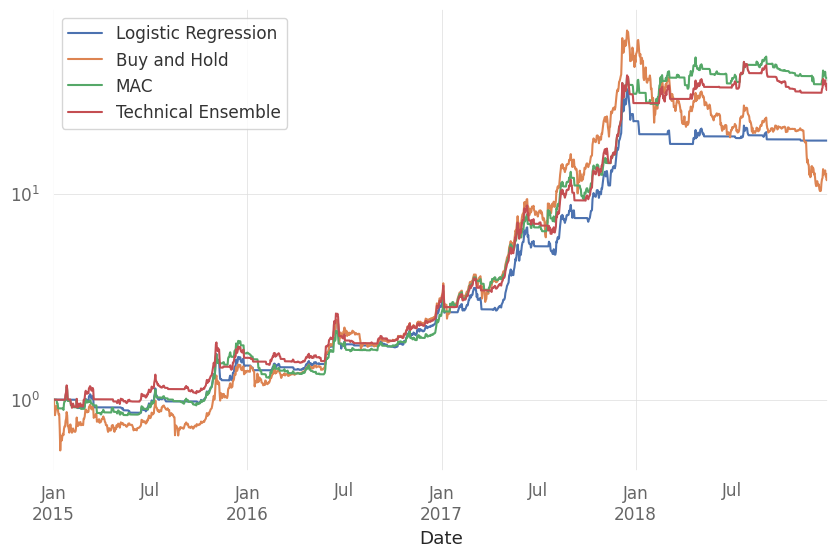

In [13]:
technical_indicators_is_df = pd.read_csv('results/technical_indicators_IS.csv', header=0, index_col=0, parse_dates=True)
technical_indicators_is_df = technical_indicators_is_df.loc[df_valid.index]
technical_indicators_is_df /= technical_indicators_is_df.iloc[0]

logit_is_backtest = Backtest(
    strategy_name='Logistic Regression',
    price_series=df_valid['Close'],
    signals=pd.Series(y_valid_pred, index=df_valid.index),
    trading_fee=0.001
)
ax = logit_is_backtest.plot(logy=True)
ax = technical_indicators_is_df[['MAC', 'Technical Ensemble']].plot(ax=ax)
ax.legend()

In [14]:
logit_is_df = pd.concat([logit_is_backtest.series_, logit_is_backtest.price_series], axis=1)
logit_is_df.to_csv('results/logistic_regression_IS.csv')
qs.stats.sharpe(logit_is_df, periods=365)

Logistic Regression    1.754663
Buy and hold           1.209229
dtype: float64

In [15]:
qs.stats.sharpe(technical_indicators_is_df[['MAC', 'Technical Ensemble']], periods=365)

MAC                   1.957683
Technical Ensemble    1.983890
dtype: float64

## Testing the baseline model out-of-sample

Although the Logistic Regression model underperfoms the technical indicators in the validation set, let's try it out-of-sample, to see if it presents a more consistent behavior when compared to the technical indicators.

In [16]:
X_test = df_test[FEATURES].values
y_test = df_test[TARGET_COL].values
y_test_proba = logit.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > logit_best_thr).astype(int)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56       854
           1       0.55      0.46      0.50       887

    accuracy                           0.53      1741
   macro avg       0.53      0.53      0.53      1741
weighted avg       0.53      0.53      0.53      1741



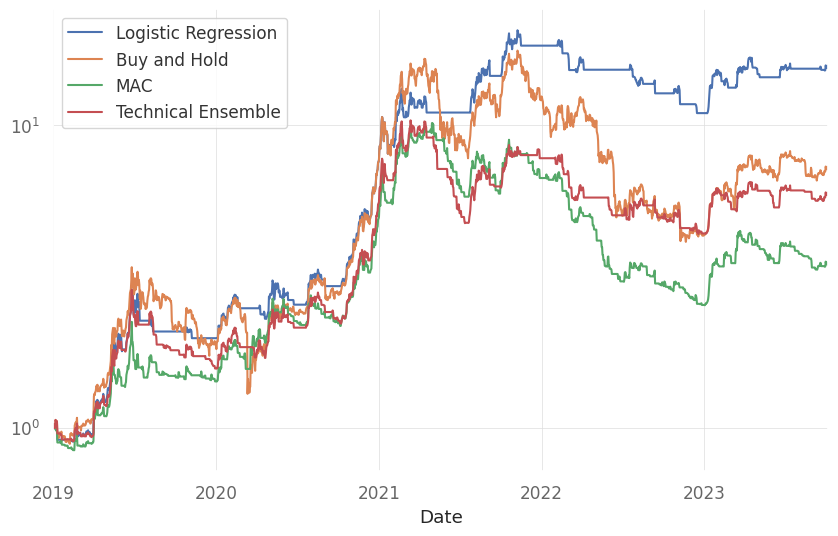

In [17]:
technical_indicators_oos_df = pd.read_csv('results/technical_indicators_OOS.csv', header=0, index_col=0, parse_dates=True)
technical_indicators_oos_df = technical_indicators_oos_df.loc[df_test.index]
technical_indicators_oos_df /= technical_indicators_oos_df.iloc[0]

logit_oos_backtest = Backtest(
    strategy_name='Logistic Regression',
    price_series=df_test['Close'],
    signals=pd.Series(y_test_pred, index=df_test.index),
    trading_fee=0.001
)
ax = logit_oos_backtest.plot(logy=True)
ax = technical_indicators_oos_df[['MAC', 'Technical Ensemble']].plot(ax=ax)
ax.legend()

In [18]:
logit_oos_df = pd.concat([logit_oos_backtest.series_, logit_oos_backtest.price_series], axis=1)
qs.stats.sharpe(logit_oos_df, periods=365)

Logistic Regression    1.531231
Buy and hold           0.959340
dtype: float64

In [19]:
qs.stats.sharpe(technical_indicators_oos_df[['MAC', 'Technical Ensemble']], periods=365)

MAC                   0.785879
Technical Ensemble    1.035204
dtype: float64

## Conclusions about the Logistic Regression model

Despite the fact that the signal-to-noise ratio is normally pretty low for financial time series datasets, it is possible to see that for Bitcoin, the Logistic Regression model achieves promising results, improving the Buy and Hold sharpe by almost 60\% (1.53 vs. 0.95), and presenting a more consistent behavior between the validation and testing sets (1.75 and 1.53 Sharpe Ratios, respectively).

Finally, let's save the created features for our next notebooks and the out-of-sample results.

In [20]:
df.to_csv('data/CMC_BTCUSD_ML_BASELINE_FEATURES.csv')
logit_oos_backtest.series_.to_csv('results/logistic_regression_OOS.csv')